Path to dataset files: /root/.cache/kagglehub/datasets/vikasukani/parkinsons-disease-data-set/versions/1
Extracted files: ['parkinsons.data']
Dataset loaded successfully from /root/.cache/kagglehub/datasets/vikasukani/parkinsons-disease-data-set/versions/1/parkinsons.data
             name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0  phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1  phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2  phon_R01_S01_3      116.682       131.111       111.555         0.01050   
3  phon_R01_S01_4      116.676       137.871       111.366         0.00997   
4  phon_R01_S01_5      116.014       141.781       110.655         0.01284   

   MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  ...  \
0           0.00007   0.00370   0.00554     0.01109       0.04374  ...   
1           0.00008   0.00465   0.00696     0.01394       0.06134  ...   
2           0.00009   0.00544   0.00

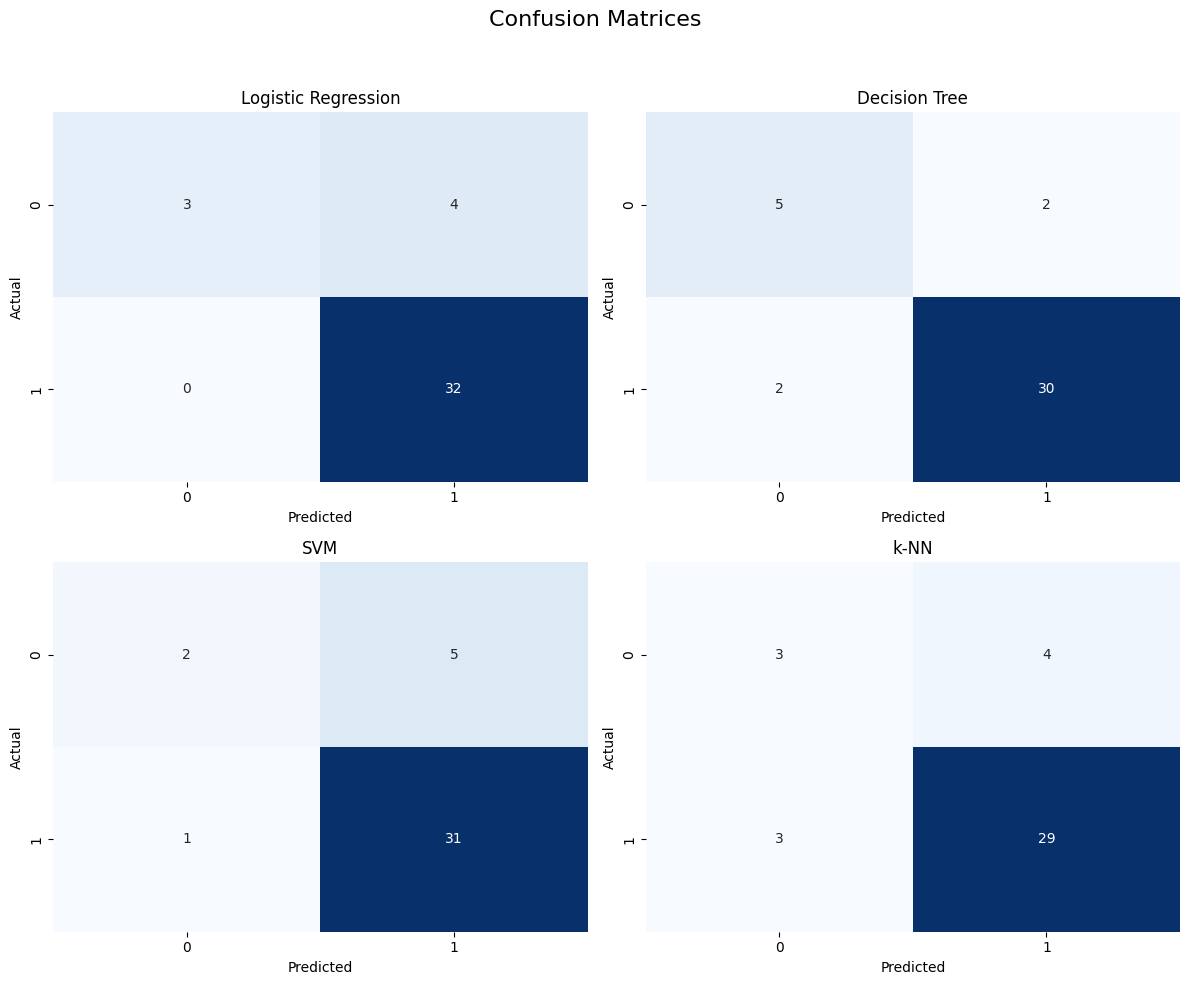


Best model: Logistic Regression
Added session for Patient Patient_001 on 2024-11-15: Deterioration Detected
Therapy Sessions for Patient Patient_001:
{'Date': '2024-11-15', 'Observations': [112.239, 126.609, 104.095, 0.00472, 4e-05, 0.00238, 0.0029, 0.00715, 0.05643, 0.517, 0.0307, 0.0353, 0.04451, 0.09211, 0.02629, 17.366, 0.640945, 0.701404, -5.634576, 0.306014, 2.419253, 0.209191], 'Prediction': 'Deterioration Detected'}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [ ]:
!pip install kagglehub librosa scikit-learn seaborn matplotlib

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import os
import kagglehub

# Download dataset from Kaggle
path = kagglehub.dataset_download("vikasukani/parkinsons-disease-data-set")
print("Path to dataset files:", path)

# List extracted files
extracted_files = os.listdir(path)
print("Extracted files:", extracted_files)

# Load dataset
dataset_file = None
for file in extracted_files:
    if file.endswith(".data"):  # Check for .data files
        dataset_file = os.path.join(path, file)
        break

if dataset_file:
    df = pd.read_csv(dataset_file, sep=",|\\s+", engine="python")
    print(f"Dataset loaded successfully from {dataset_file}")
else:
    print("No .data file found in the extracted files. Please check the files.")
    exit()

print(df.head())

# Split features and target
X = df.drop(columns=['name', 'status'])
y = df['status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize classifiers
log_reg = LogisticRegression(max_iter=1000)
decision_tree = DecisionTreeClassifier()
svm = SVC(probability=True)
knn = KNeighborsClassifier()

# Train classifiers
log_reg.fit(X_train, y_train)
decision_tree.fit(X_train, y_train)
svm.fit(X_train, y_train)
knn.fit(X_train, y_train)

# Predictions
log_reg_pred = log_reg.predict(X_test)
dt_pred = decision_tree.predict(X_test)
svm_pred = svm.predict(X_test)
knn_pred = knn.predict(X_test)

# Evaluate accuracy
log_reg_accuracy = accuracy_score(y_test, log_reg_pred)
dt_accuracy = accuracy_score(y_test, dt_pred)
svm_accuracy = accuracy_score(y_test, svm_pred)
knn_accuracy = accuracy_score(y_test, knn_pred)

print(f"Logistic Regression Accuracy: {log_reg_accuracy * 100:.2f}%")
print(f"Decision Tree Accuracy: {dt_accuracy * 100:.2f}%")
print(f"SVM Accuracy: {svm_accuracy * 100:.2f}%")
print(f"k-NN Accuracy: {knn_accuracy * 100:.2f}%")

# Confusion Matrices
conf_matrices = {
    'Logistic Regression': confusion_matrix(y_test, log_reg_pred),
    'Decision Tree': confusion_matrix(y_test, dt_pred),
    'SVM': confusion_matrix(y_test, svm_pred),
    'k-NN': confusion_matrix(y_test, knn_pred)
}

# Plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Confusion Matrices", fontsize=16)

for ax, (name, cm) in zip(axes.flatten(), conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Choose the best model based on accuracy
accuracies = {
    'Logistic Regression': log_reg_accuracy,
    'Decision Tree': dt_accuracy,
    'SVM': svm_accuracy,
    'k-NN': knn_accuracy
}
best_model_name = max(accuracies, key=accuracies.get)
best_model = {'Logistic Regression': log_reg,
              'Decision Tree': decision_tree,
              'SVM': svm,
              'k-NN': knn}[best_model_name]
print(f"\nBest model: {best_model_name}")

# Patient session management
patient_sessions = {}

def add_therapy_session(patient_id, session_date, observations):
    if patient_id not in patient_sessions:
        patient_sessions[patient_id] = []

    features = np.array(observations).reshape(1, -1)
    deterioration_prediction = best_model.predict(features)[0]
    status = 'Deterioration Detected' if deterioration_prediction == 1 else 'No Deterioration'

    session = {
        'Date': session_date,
        'Observations': observations.tolist(),
        'Prediction': status
    }
    patient_sessions[patient_id].append(session)
    print(f"Added session for Patient {patient_id} on {session_date}: {status}")

def view_patient_sessions(patient_id):
    if patient_id not in patient_sessions:
        print(f"No records found for Patient {patient_id}.")
        return
    print(f"Therapy Sessions for Patient {patient_id}:")
    for session in patient_sessions[patient_id]:
        print(session)

# Test with a sample patient
sample_patient_id = "Patient_001"
sample_date = datetime.now().strftime("%Y-%m-%d")
sample_observations = X_test.iloc[0].values

add_therapy_session(sample_patient_id, sample_date, sample_observations)
view_patient_sessions(sample_patient_id)
